# General Equilibrium.

Under a General Equilibrium model we also have to allow the model to determine the interest rate and the wage in equilibrium.
From the problem of the firms we know that: 
$$
F_{l}'(k,l) = w = (1-\alpha) K ^{\alpha}
$$

$$
F_{k}'(k,l) = r = \alpha K ^{\alpha-1} -\delta
$$

Where the last equality holds under Cobb-Douglass production function.  So now we can rewritte as :

$$
K = \left(\frac{r+\delta}{\alpha}\right)^{\frac{1}{\alpha-1}} 
$$

To calibrate the model I will follow Ayagari. Therefore $\alpha=0.36$ and $\delta=0.08$. 

My strategy here is to first compute the graph of supply vs demand of capital for a given interest rate, and then using the interestion between those two graphs compute the stationary recursive equilibrium. 

So let's start by defining all the funcitons that will be used and establishing the parameters of the model:

## Functions: 



In [2]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe

rho=0.06
sigma=2
c_bar=100
gamma=0.3
sigma_y=0.4
y=1.2
beta=1/(1+rho)
Y1 = np.array([y-sigma_y, y+sigma_y])
PI1 = [[(1+gamma)/2, (1-gamma)/2], [(1-gamma)/2, (1+gamma)/2]]
n=100
epsilon=0.05
Amax=20
omega = -111111111111111
alpha = 0.33                # Following Ayagari
delta=0.08                  # Following Ayagari


#Amin = round(-min(Y1)*((1+r)/r))+3
Amin = 0

grid = np.linspace(Amin,Amax,n)

def find_values(g):
    
    ''' This function returns the value of capital and the wage for a given
    interest rate, using the FOC of the firms.'''
    
    k = ((g+delta)/alpha)**(1/(alpha-1))
    
    w = (1-alpha) * k**(alpha)
    
    return k,w


def utility (a0,a1,w,y,r):
    
    ''' This function retunrs the utility under CRRA preferences'''
    
    c = w*y+a0*(1+r)-a1
   
    if c>=0: 
        
        u = (((c)**(1-sigma)-1)/(1-sigma))
            
    else:
        u=omega
    return u


def feasible(a0,y,w,r):
    "Returns the maximum feasible k_j given k_i with the form : f(k_i)+(1-δ)k_i"
    # Inputs:
        #--> Capital today:    k1
    f = w*y+(1+r)*a0
    return f


def VFI_Uncertainty(M,epsilon):
    "This function returns the solution for the Bellman equation using Value Function Iteration algorithim and counts the number of iterations "
    # Inputs:
        # --> M (Initial value)
        # --> V (Initial guess)
        # --> epsilon (tolerance)    
    # Output:
        # --> Returns fixed point value function.
       
    X = np.zeros(shape=(n*len(Y1),n))
            
    V= np.zeros(shape=(1,n*len(Y1)))
            
    Vnew = np.zeros(shape=(1,n*len(Y1)))
    
    g = np.zeros(shape=(1,n*len(Y1)))      # Array for optimal decision rule

            
    W = np.zeros(shape=(1,n*len(Y1)))
            
    # Get the max of all the possible X[j] = M + betaV given j, assuming the initial guess is V=0:
            
    for i in range(n*len(Y1)):
        Vnew[0][i] = np.amax(M[i][:])
        g[0][i] = np.argmax(X[i][:])        # The optimal decision rule
                
        # Generate the new value function and repeat the process until tolerance is satisfied:   
            
                
    while np.any(abs(V-Vnew)>=epsilon):
        V = Vnew.copy()
        for i in range(n*len(Y1)):
            if i<=n-1:
                Z = np.array([Vnew[0][i] , Vnew[0][i+n]])
                        
                W[0][i] = np.inner(PI1[0] , Z)
                        
            else: 
                Z = np.array([Vnew[0][i-n] , Vnew[0][i]])
                        
                W[0][i] = np.inner(PI1[1] , Z)     
         
        for x in range(len(Y1)):
            for i in range(n):
                for j in range(n):
                    X[i+n*x][j] = M[i+n*x][j] + beta*W[0][j+n*x]
                
        for i in range(n*len(Y1)):
            Vnew[0][i] = np.amax(X[i][:])
            g[0][i] = np.argmax(X[i][:])      
            
                           
    return V , g




def gen_M(Y1,w,r):
    
    '''This function generates the matrix M with all the feasible
    utiilty levels given combinations of assets'''
    
    M = np.zeros(shape=(n*len(Y1),n))
            
    for x in range(len(Y1)):
        for i in range(n):
            for j in range(n):
                if feasible(grid[i],Y1[x],w,r) >= grid[j]: 
                    M[i+n*x][j] = utility(grid[i],grid[j],w,Y1[x],r) # Gives the element ij of matrix M
                else: 
                    M[i+n*x][j] = omega
    return M


def find_nearest(array, value):
    
    '''This function takes the nearest feasible value in a grid. Takes as a input a value
    that might not be in the grid, and returns the nearest value in that grid.'''
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

   
# Find the invariant distribution of assets: 
  
def assets_path_random_new(grid,policy,initial_assets,T,Y,PI):
    
    ''' This function returns the level of assets for an individual after T periods
    facing income shocks every period according to the transition matrix PI.'''
    
    
    PolicyBad = policy[0][0:n]
    PolicyGood = policy[0][n:]
    
    g = find_nearest(grid,initial_assets)
    
    a = np.random.binomial(1,1/2)

    for i in range(T):
        
        if i ==0:
            
            c = np.where(grid == g)
            
        if i>0:
        
            if a==1: 
                
                c = np.int(PolicyGood[c])
        
                a = np.random.binomial(1,PI[1][1])
                
                                
            if a==0:
                
                c = np.int(PolicyBad[c])
        
                a = np.random.binomial(1,PI[0][1])
   
    lastasset = grid[c]
        
    
    return lastasset
    


def find_stationary_new(policy,Y,PI,periods,individuals,grid,initial_assets):
    
    ''' This funciton simulates the stationary distribution of agents by 
    generating the desired amount of individuals and then itereate over a big enough
    amount of periods to make sure the distribution is stationary'''
    
    rand_ass = np.zeros(shape=(individuals,periods))
    
    
    for i in range(individuals):
        
    
        assets =  assets_path_random_new(grid,policy,initial_assets,periods,Y,PI)
    
        rand_ass[i][:]  = assets
    
    stati = rand_ass[:,-1]
    
    return stati

   
    
def frequency(x):
    
    ''' This function computes the frequency of each value of the stationary 
    distribution. This is a key step to later compute the total amount of assets'''
    
    output = []
    for i in x:
        if i not in output:
            output.append(i)
            
    frec = np.zeros(shape=(len(output),2))
    
    a=0
    
    for i in output:
        
        c = find_nearest(grid, i)
        
        frec[a][0] = np.count_nonzero(x==c)/len(x)
        frec[a][1] = i
        
        a+=1
    
    return frec



def Ea(sta,policy):
    
    '''This function computes the supply of demand for a given
    level of interest rate'''
    
    PolicyBad = policy[0][0:n]
    PolicyGood = policy[0][n:]
    
    val = sta[:,1]
    freq = sta[:,0]
    
    E = np.zeros(len(val))
    
    for i in range(len(val)):
        
        E[i] = val[i] * freq[i]
        
    Ea = sum(E)
    
    return Ea

       
        
    

def solve():
    
    '''This function iterates all the economy for different values of 
    interest rates to find the path of supply of assets.'''
    
    grid_r = np.linspace(-delta+0.01,rho,20)
       
    Ea_path = np.zeros(len(grid_r))
    
    for i in range(len(grid_r)):
        
        r = grid_r[i]
        
        k,w = find_values(r)
        
        M = gen_M(Y1,w,r)
        
        ValueFunction, Policy = VFI_Uncertainty(M,epsilon)
        
        stationary = find_stationary_new(Policy,Y1,PI1,2000,2000,grid,3)
        
        values = frequency(stationary)
        
        EAss = Ea(values,Policy)
               
        Ea_path[i] = EAss
        
    return Ea_path

def capital_to_r(sup):
    
    '''This funciton returs the interest rate associated to a given
    demand of assets using the FOC of the firms.'''
    
    dem = alpha*sup**(alpha-1)-delta
    
    return dem



## Strategy: 

Once I have defined all the funcitons I can describe what is my strategy to compute the demand and supply of capital. To do so I will rigurosly follow the steps described in the PS. This process is just giving words to what my function $\textbf{solve()}$ is doing. 

1. Generate a grid to determine the values of the interest rate to evaluate. 

2. Find its associated wage and capital level using the focs of the firm. 

3. Since now we know the wage, we can solve for the value function and policy function of the Household. 

4. With the policy function of the agent I will simulate 2000 agents facing income shocks over 2000 periods using the transition probability PI to see what is the stationary distibution of the economy. 

5. With the statinoary distribution of assets compute the supply of assets.

6. Repeat this process over the full grid of interest rates. 

7. Once I have the suppply of assets for each interest rate, I can compute the interest rate if this supply was demand using the FOC of the firm. With this I will get the demand of capital for some interest rates. 

8. Do the plot ! 

## Results:

In [3]:
qe.tic()   
eapath = solve()
qe.toc()  
 

TOC: Elapsed: 0:15:31.62


931.6231780052185

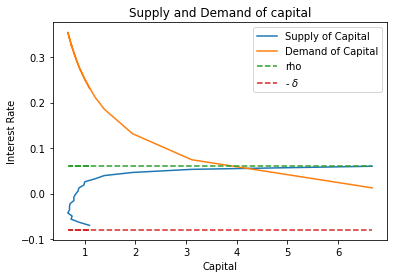

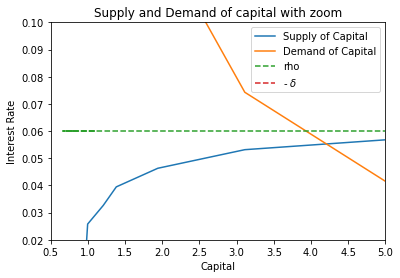

In [4]:
#  Plot the results:

r_space = np.linspace(-delta+0.01,rho,20)

demand = capital_to_r(eapath)

fig, ax = plt.subplots()
ax.plot(eapath,r_space,label='Supply of Capital')
ax.plot(eapath,demand,label='Demand of Capital')
ax.plot(eapath,rho*np.ones(20),'--',label='rho')
ax.plot(eapath,-delta*np.ones(20),'--',label='- $\delta$')
plt.ylabel('Interest Rate')
plt.xlabel('Capital')
plt.title('Supply and Demand of capital')
plt.legend() 

fig, ax = plt.subplots()
ax.plot(eapath,r_space,label='Supply of Capital')
ax.plot(eapath,demand,label='Demand of Capital')
ax.plot(eapath,rho*np.ones(20),'--',label='rho')
ax.plot(eapath,-delta*np.ones(20),'--',label='- $\delta$')
ax.set(xlim=(0.5, 5), ylim=(0.02, 0.1))
plt.ylabel('Interest Rate')
plt.xlabel('Capital')
plt.title('Supply and Demand of capital with zoom')
plt.legend() 


### Results: 

As we can see this is the desired result. I have found a graph very closed to that of Ayagari (1994) that shows how capital demand is decrasing in the interest rate and capital supply is increasing in the interest rate. The intention now is to find the point at which supply and demand interesect to get the stationary recursive equilibrium. 

Notice that the most important here is to clear the assets market. This is because labor is supplied inelastically so the market for labor will always clear and by Walra's law whe know that if we have n markets and n-1 clear, then the remaining will also clear. Therefore, if clear the assets market, since the labor market is always claered, we will also clear the goods market.  So let's now focus on clearing the assets market. 

### Strategy to solve the optimal interest rate. 

Since my code is a bit slow, around 30 seconds per iteration, I need to do the less iterations as possible. For this reason I will redefine my grid around the interest rates that where minimizing the distance in the previous graph. Then I will see what new interest rate gives the minimum difference in demand and supply. If this difference is acceptable I will consider this interest rate the good one. Otherwise I will redefine my grid around that point. 

In [5]:
# Now I need to find the value at which supply and demand cross. This will be the recursive stationary competitive 
# equilibrium since all the markets will clear there. 


# I will now compute the value of the interest rate that is minimizing those two curves. 

z1 = [abs(demand-r_space)]

a = np.argmin(z1)

r_demand = demand[a]
r_supply = r_space[a]



In [8]:
def solve(grid_r):
    
    '''This function iterates all the economy for different values of 
    interest rates to find the path of supply of assets.'''
       
    Ea_path = np.zeros(len(grid_r))
    
    for i in range(len(grid_r)):
        
        r = grid_r[i]
        
        k,w = find_values(r)
        
        M = gen_M(Y1,w,r)
        
        ValueFunction, Policy = VFI_Uncertainty(M,epsilon)
        
        stationary = find_stationary_new(Policy,Y1,PI1,2000,2000,grid,3)
        
        values = frequency(stationary)
        
        EAss = Ea(values,Policy)
               
        Ea_path[i] = EAss
        
    return Ea_path

def find(w1,w2,epsilon):
    
    supply=1
    demand=0
    
    k_demand = np.zeros(20)
    
    r1=w1
    r2=w2
    
    while abs(supply-demand)>epsilon:
        r_val = np.linspace(r1,r2,20)
        k_supply = solve(r_val)
        for i in range(len(k_supply)):
            k_demand[i] = find_values(r_val[i])[0]
        
        a = np.argmin(abs(k_demand-k_supply))
        
        r = r_val[a]
        
        demand = k_demand[a]
        supply = k_supply[a]
        
        if a <=3:
            
            r1 = r_val[0]-0.03
            r2 = r_val[5]
        if a>=17:
            
            r1= r_val[13]
            r2=r_val[19]+0.03
        else:
            r1=r_val[a-3]
            r2=r_val[a+3]
        
    return r


In [10]:
r_min = find(r_demand,r_supply,0.2)   # I put a high tolerance to wait less, code runs slowly.

In [23]:
print(r_min)

0.055380851756161316


(array([ 73.,  43., 139.,  40.,  61.,  88.,  40.,  64.,  82.,  40.,  53.,
         87.,  37.,  62.,  91.,  43.,  62., 102.,  60.,  45.,  95.,  63.,
        101.,  49.,  57., 123.,  49.,  23.,  56.,  14.,   9.,  22.,  10.,
          5.,   3.,   1.,   2.,   2.,   2.,   2.]),
 array([ 0.        ,  0.27272727,  0.54545455,  0.81818182,  1.09090909,
         1.36363636,  1.63636364,  1.90909091,  2.18181818,  2.45454545,
         2.72727273,  3.        ,  3.27272727,  3.54545455,  3.81818182,
         4.09090909,  4.36363636,  4.63636364,  4.90909091,  5.18181818,
         5.45454545,  5.72727273,  6.        ,  6.27272727,  6.54545455,
         6.81818182,  7.09090909,  7.36363636,  7.63636364,  7.90909091,
         8.18181818,  8.45454545,  8.72727273,  9.        ,  9.27272727,
         9.54545455,  9.81818182, 10.09090909, 10.36363636, 10.63636364,
        10.90909091]),
 <a list of 40 Patch objects>)

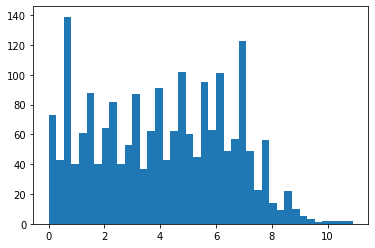

In [11]:
# Compute the histogram of the stationary distribution:

k,w = find_values(r_min)
        
M = gen_M(Y1,w,r_min)
        
ValueFunction, Policy = VFI_Uncertainty(M,epsilon)
        
stationary = find_stationary_new(Policy,Y1,PI1,2000,2000,grid,3)
        
values = frequency(stationary)
        
ksupplied = Ea(values,Policy)

plt.hist(stationary,bins=40)         




Text(0, 0.5, 'Frequency')

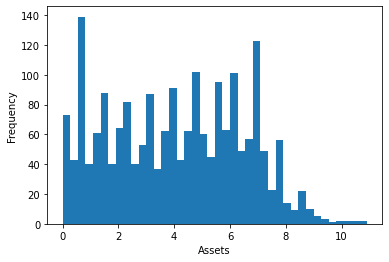

In [12]:
plt.hist(stationary,bins=40)         
plt.xlabel('Assets')
plt.ylabel('Frequency')

### Compute Stats To Measure Inequality

In [22]:
 # Generate a function that will compute the share of assets owned by each percentile. 
from tabulate import tabulate

def percentile(values,percent,top):
    
    '''This function takes as inputs the percentile to be computed and the stationary distribution
    of assets and returns the share of assets owned by this percentile'''
    
    ordered = sorted(values)                 # Order the assets owned in the economy
    
    
    if top==False:
        
        x = np.int(len(values)*(percent/100))    # The interval [0,x] is the agents that belong to percent.
        
        share = sum(ordered[:x])/sum(ordered)
    
    else: 
       
        x = np.int(len(values)*(1-(percent)/100))    # The interval [0,x] is the agents that belong to percent.
        
        share = sum(ordered[x:])/sum(ordered)
           
    return share

top1 =  percentile(stationary,1,top=True)
top10 =  percentile(stationary,10,top=True)
bottom50 =  percentile(stationary,50,top=False)

print('The top 1% has '+str(round(top1*100,2))+'% of wealth of the economy')
print('The top 10% has '+str(round(top10*100,2))+'% of wealth of the economy')
print('The bottom 50% has '+str(round(bottom50*100,2))+'% of wealth of the economy')

# To replicate the Table 1 of the Chapter 11: 

Q1 = percentile(stationary,20,top=False)
Q2 = percentile(stationary,40,top=False) - percentile(stationary,20,top=False)
Q3 = percentile(stationary,60,top=False) - percentile(stationary,40,top=False)
Q4 = percentile(stationary,80,top=False) - percentile(stationary,60,top=False)
Q5 = percentile(stationary,20,top=True)

print('Q1 '+str(round(Q1*100,2))+'% of wealth of the economy')
print('Q2 '+str(round(Q2*100,2))+'% of wealth of the economy')
print('Q3 '+str(round(Q3*100,2))+'% of wealth of the economy')
print('Q4 '+str(round(Q4*100,2))+'% of wealth of the economy')
print('Q5 '+str(round(Q5*100,2))+'% of wealth of the economy')



The top 1% has 2.37% of wealth of the economy
The top 10% has 19.54% of wealth of the economy
The bottom 50% has 24.59% of wealth of the economy
Q1 3.69% of wealth of the economy
Q2 11.78% of wealth of the economy
Q3 20.26% of wealth of the economy
Q4 27.96% of wealth of the economy
Q5 36.31% of wealth of the economy


# Copmute the distribution T periods after Covid Shock, Starting from the statinoary distribution. 



In [14]:
def assets_path_random_new_covid(grid,policy,initial_assets,T,Y,PI,period_shock,phigh_low,phigh_high):
    
    ''' This function returns the level of assets for an individual after T periods
    facing income shocks every period according to the transition matrix PI.'''
    
    
    PolicyBad = policy[0][0:n]
    PolicyGood = policy[0][n:]
    
    g = find_nearest(grid,initial_assets)
    
    a = np.random.binomial(1,8/10)

    for i in range(T):
        
        if i ==0:
            
            c = np.where(grid == g)
            
        if i == period_shock:
            
            if a==1: 
                
                c = np.int(PolicyGood[c])
        
                a = np.random.binomial(1,phigh_high)
                
                                
            if a==0:
                
                c = np.int(PolicyBad[c])
        
                a = np.random.binomial(1,phigh_low)
            
            
        
        else:
        
            if a==1: 
                
                c = np.int(PolicyGood[c])
        
                a = np.random.binomial(1,PI[1][1])
                
                                
            if a==0:
                
                c = np.int(PolicyBad[c])
        
                a = np.random.binomial(1,PI[0][1])
   
    lastasset = grid[c]
        
    
    return lastasset
    


def find_stationary_new_covid(policy,Y,PI,periods,individuals,grid,initial_assets,period_shock,phigh_high,phigh_low):
    
    ''' This funciton simulates the stationary distribution of agents by 
    generating the desired amount of individuals and then itereate over a big enough
    amount of periods to make sure the distribution is stationary'''
    
    rand_ass = np.zeros(shape=(individuals,periods))
    
    
    for i in range(individuals):
        
    
        assets =  assets_path_random_new_covid(grid,policy,initial_assets,periods,Y,PI,period_shock,phigh_high,phigh_low)
    
        rand_ass[i][:]  = assets
    
    stati = rand_ass[:,-1]
    
    return stati

In [15]:
# Compute the stationary distribution

stationary_covid = find_stationary_new_covid(Policy,Y1,PI1,2000,2000,grid,3,1998,0,0)   # In the last period everybody gets low productivity


Text(0, 0.5, 'Frequency')

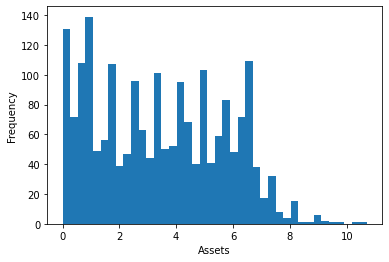

In [16]:
# Plot the distribution:

plt.hist(stationary_covid,bins=40)
plt.xlabel('Assets')
plt.ylabel('Frequency')


In [17]:
# Compute the statistics:

top1_covid =  percentile(stationary_covid,1,top=True)
top10_covid=  percentile(stationary_covid,10,top=True)
bottom50_covid =  percentile(stationary_covid,50,top=False)

print('The top 1% has '+str(round(top1_covid*100,2))+'% of wealth of the economy')
print('The top 10% has '+str(round(top10_covid*100,2))+'% of wealth of the economy')
print('The bottom 50% has '+str(round(bottom50_covid*100,2))+'% of wealth of the economy')
 

Q1_covid = percentile(stationary_covid,20,top=False)
Q2_covid = percentile(stationary_covid,40,top=False) - percentile(stationary_covid,20,top=False)
Q3_covid = percentile(stationary_covid,60,top=False) - percentile(stationary_covid,40,top=False)
Q4_covid = percentile(stationary_covid,80,top=False) - percentile(stationary_covid,60,top=False)
Q5_covid = percentile(stationary_covid,20,top=True)

print('Q1 '+str(round(Q1_covid*100,2))+'% of wealth of the economy')
print('Q2 '+str(round(Q2_covid*100,2))+'% of wealth of the economy')
print('Q3 '+str(round(Q3_covid*100,2))+'% of wealth of the economy')
print('Q4 '+str(round(Q4_covid*100,2))+'% of wealth of the economy')
print('Q5 '+str(round(Q5_covid*100,2))+'% of wealth of the economy')

The top 1% has 2.63% of wealth of the economy
The top 10% has 21.08% of wealth of the economy
The bottom 50% has 21.05% of wealth of the economy
Q1 2.56% of wealth of the economy
Q2 9.92% of wealth of the economy
Q3 19.5% of wealth of the economy
Q4 28.88% of wealth of the economy
Q5 39.15% of wealth of the economy


# Suppose now Covid Lasts More Periods.


In [18]:
def assets_path_random_longcovid(grid,policy,initial_assets,T,Y,PI,period_shock,phigh_low,phigh_high):
    
    ''' This function returns the level of assets for an individual after T periods
    facing income shocks every period according to the transition matrix PI.'''
    
    
    PolicyBad = policy[0][0:n]
    PolicyGood = policy[0][n:]
    
    g = find_nearest(grid,initial_assets)
    
    a = np.random.binomial(1,8/10)

    for i in range(T):
        
        if i ==0:
            
            c = np.where(grid == g)
            
        if i == period_shock:
            
            if a==1: 
                
                c = np.int(PolicyGood[c])
        
                a = np.random.binomial(1,phigh_high)
                
                                
            if a==0:
                
                c = np.int(PolicyBad[c])
        
                a = np.random.binomial(1,phigh_low)
        
        if i == period_shock+1:
            
            if a==1: 
                
                c = np.int(PolicyGood[c])
        
                a = np.random.binomial(1,phigh_high)
                
                                
            if a==0:
                
                c = np.int(PolicyBad[c])
        
                a = np.random.binomial(1,phigh_low)
            
        if i == period_shock+2:
            
            if a==1: 
                
                c = np.int(PolicyGood[c])
        
                a = np.random.binomial(1,phigh_high)
                
                                
            if a==0:
                
                c = np.int(PolicyBad[c])
        
                a = np.random.binomial(1,phigh_low)
            
            
        
        else:
        
            if a==1: 
                
                c = np.int(PolicyGood[c])
        
                a = np.random.binomial(1,PI[1][1])
                
                                
            if a==0:
                
                c = np.int(PolicyBad[c])
        
                a = np.random.binomial(1,PI[0][1])
   
    lastasset = grid[c]
        
    
    return lastasset
    


def find_stationary_longcovid(policy,Y,PI,periods,individuals,grid,initial_assets,period_shock,phigh_high,phigh_low):
    
    ''' This funciton simulates the stationary distribution of agents by 
    generating the desired amount of individuals and then itereate over a big enough
    amount of periods to make sure the distribution is stationary'''
    
    rand_ass = np.zeros(shape=(individuals,periods))
    
    
    for i in range(individuals):
        
    
        assets =  assets_path_random_new_covid(grid,policy,initial_assets,periods,Y,PI,period_shock,phigh_high,phigh_low)
    
        rand_ass[i][:]  = assets
    
    stati = rand_ass[:,-1]
    
    return stati

In [19]:
# Compute the distribution: 

stationary_longcovid = find_stationary_longcovid(Policy,Y1,PI1,2000,2000,grid,3,1995,0,0)   # In the last period everybody gets low productivity



Text(0, 0.5, 'Frequency')

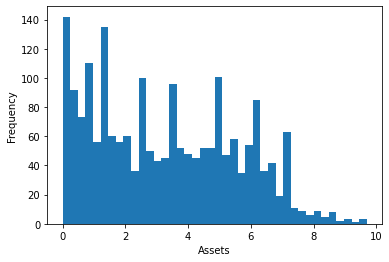

In [20]:
# Plot the distribution:

plt.hist(stationary_longcovid,bins=40)
plt.xlabel('Assets')
plt.ylabel('Frequency')

In [21]:
# Compute the statistics:

top1_longcovid =  percentile(stationary_longcovid,1,top=True)
top10_longcovid=  percentile(stationary_longcovid,10,top=True)
bottom50_longcovid =  percentile(stationary_longcovid,50,top=False)

print('The top 1% has '+str(round(top1_longcovid*100,2))+'% of wealth of the economy')
print('The top 10% has '+str(round(top10_longcovid*100,2))+'% of wealth of the economy')
print('The bottom 50% has '+str(round(bottom50_longcovid*100,2))+'% of wealth of the economy')
 

Q1_longcovid = percentile(stationary_longcovid,20,top=False)
Q2_longcovid = percentile(stationary_longcovid,40,top=False) - percentile(stationary_longcovid,20,top=False)
Q3_longcovid = percentile(stationary_longcovid,60,top=False) - percentile(stationary_longcovid,40,top=False)
Q4_longcovid = percentile(stationary_longcovid,80,top=False) - percentile(stationary_longcovid,60,top=False)
Q5_longcovid = percentile(stationary_longcovid,20,top=True)

print('Q1 '+str(round(Q1_longcovid*100,2))+'% of wealth of the economy')
print('Q2 '+str(round(Q2_longcovid*100,2))+'% of wealth of the economy')
print('Q3 '+str(round(Q3_longcovid*100,2))+'% of wealth of the economy')
print('Q4 '+str(round(Q4_longcovid*100,2))+'% of wealth of the economy')
print('Q5 '+str(round(Q5_longcovid*100,2))+'% of wealth of the economy')

The top 1% has 2.71% of wealth of the economy
The top 10% has 22.17% of wealth of the economy
The bottom 50% has 19.8% of wealth of the economy
Q1 2.56% of wealth of the economy
Q2 9.17% of wealth of the economy
Q3 18.79% of wealth of the economy
Q4 29.0% of wealth of the economy
Q5 40.49% of wealth of the economy
